# Implementation

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import warnings
import numpy as np
import theano.tensor as tt

from pymc3 import Model, Normal, Wald, glm, plot_posterior_predictive_glm, sample

In [2]:
warnings.filterwarnings("ignore")

In [3]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [4]:
RANDOM_SEED = 2022
rng = np.random.default_rng(RANDOM_SEED)

## Data loading

In [5]:
f = open("spambase.columns", "r")
headers = [line.split(":")[0] for line in f]+["class"]

df = pd.read_csv("spambase.data", header=None) 
df.columns = headers
df.insert(0, "intercept", 1)
df["class"] = df["class"].replace(0,-1)

df

,intercept,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,class
0,1,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,...,0.000,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,1,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,...,0.010,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,1,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,...,0.000,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,1,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,...,0.000,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,1,0.31,0.00,0.62,0.0,0.00,0.31,0.00,0.00,0.00,...,0.000,0.232,0.0,0.000,0.000,0.000,1.142,3,88,-1
4597,1,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.000,0.000,0.0,0.353,0.000,0.000,1.555,4,14,-1
4598,1,0.30,0.00,0.30,0.0,0.00,0.00,0.00,0.00,0.00,...,0.102,0.718,0.0,0.000,0.000,0.000,1.404,6,118,-1
4599,1,0.96,0.00,0.00,0.0,0.32,0.00,0.00,0.00,0.00,...,0.000,0.057,0.0,0.000,0.000,0.000,1.147,5,78,-1


In [6]:
# Compute X by multiplying each row by the class
X = np.array(df.drop('class', axis=1)) * np.array(df["class"]).reshape(-1,1)

In [7]:
# Number of samples and of dimensions
n, k = X.shape
n, k

(4601, 58)

In [8]:
# Compute variance matrix
sigma = df.drop('class', axis=1).std(axis=0)
sigma[0] = 1
sigma2 = np.diag(sigma**2)
sigma2_inv = np.diag(1/sigma**2)
sigma2_inv.shape

(58, 58)

In [9]:
def numerical(vector):
    positions = []
    vals = []
    for (position, elt) in enumerate(vector):
        if np.isinf(np.abs(elt)):
            positions.append(position)
            vals.append("inf")
        if np.isnan(elt):
            positions.append(position)
            vals.append("nan")
    return len(positions) != 0, positions, vals

In [10]:
def sample_L1(nu,T):

    betas = np.zeros((T,k))
    lambdas = np.zeros((T,n))
    omegas = np.zeros((T,k))

    betas[0] = rng.normal(0,1,size=k)
    lambdas[0] = rng.normal(0,1,size=n)
    omegas[0] = rng.normal(0,1,size=k)

    lambdas_idx = list(range(n))
    omegas_idx = list(range(k))

    for t in range(1,T):
        
        if t % 100 == 0:
            print("Step {}".format(t))

        num_omega = numerical(1/omegas[t-1])
        if num_omega[0]:
            print("At time", t)
            idx, tags = num_omega[1], num_omega[2]
            print("Found a numerical issue for omega, in position {}, with value {}".format(i,tag))
            print("Sparsity condition reached for beta[{}]".format(i))
            betas[:,idx] = 0
            for i in idx:
                if i in omegas_idx:
                    omegas_idx.remove(i)
            print('Remaining coeffs in omega : {}'.format(len(omegas_idx)))

        num_lambda = numerical(1/lambdas[t-1])
        if num_lambda[0]:
            print("At time", t)
            idx, tag = num_lambda[1], num_lambda[2]
            print("Found a numerical issue for lambda, in position {}, with value {}".format(i,tag))
            print("Support vector found at index {}".format(i))
            lambdas[:,idx] = np.nan
            for i in idx:
                if i in lambdas_idx:
                    lambdas_idx.remove(i)
            print('Remaining coeffs in lambda : {}'.format(len(lambdas_idx)))

        # Computing B and b
        term1 = nu**(-2)* sigma2_inv[omegas_idx,:][:,omegas_idx] @ np.diag(1/omegas[t-1][omegas_idx])
        term2 = X[lambdas_idx,:][:,omegas_idx].T @ np.diag(1/lambdas[t-1][lambdas_idx]) @ X[lambdas_idx,:][:,omegas_idx]
        B = term1 + term2
        b = B @ X[lambdas_idx,:][:,omegas_idx].T @ (np.ones(len(lambdas_idx)) + 1/lambdas[t-1][lambdas_idx])

        # Sampling beta using previous state
        betas[t][omegas_idx] = rng.multivariate_normal(b, cov=B)

        # Sampling lambda using beta
        for i in lambdas_idx:
            lambda_inv = rng.wald(1/np.abs(1-X[i][omegas_idx].T @ betas[t][omegas_idx]), 1)
            if lambda_inv == 0.0:
                lambdas[t,i] = np.inf
            else:
                lambdas[t,i] = 1/lambda_inv

        # Sampling omega using beta
        for j in omegas_idx:
            omega_inv = rng.wald(nu*sigma[j]/np.abs(betas[t,j]), 1)
            if omega_inv == 0.0:
                omegas[t,j] = np.inf
            else:
                omegas[t,j] = 1/omega_inv
    
    return betas

In [11]:
T = 1000
nu = 1

betas1 = sample_L1(nu,T)

Step 100
Step 200
Step 300
Step 400
Step 500
Step 600
Step 700
Step 800
Step 900


In [12]:
T = 1000
nu = 1e-3

betas2 = sample_L1(nu,T)

Step 100
Step 200
Step 300
Step 400
Step 500
Step 600
Step 700
Step 800
Step 900


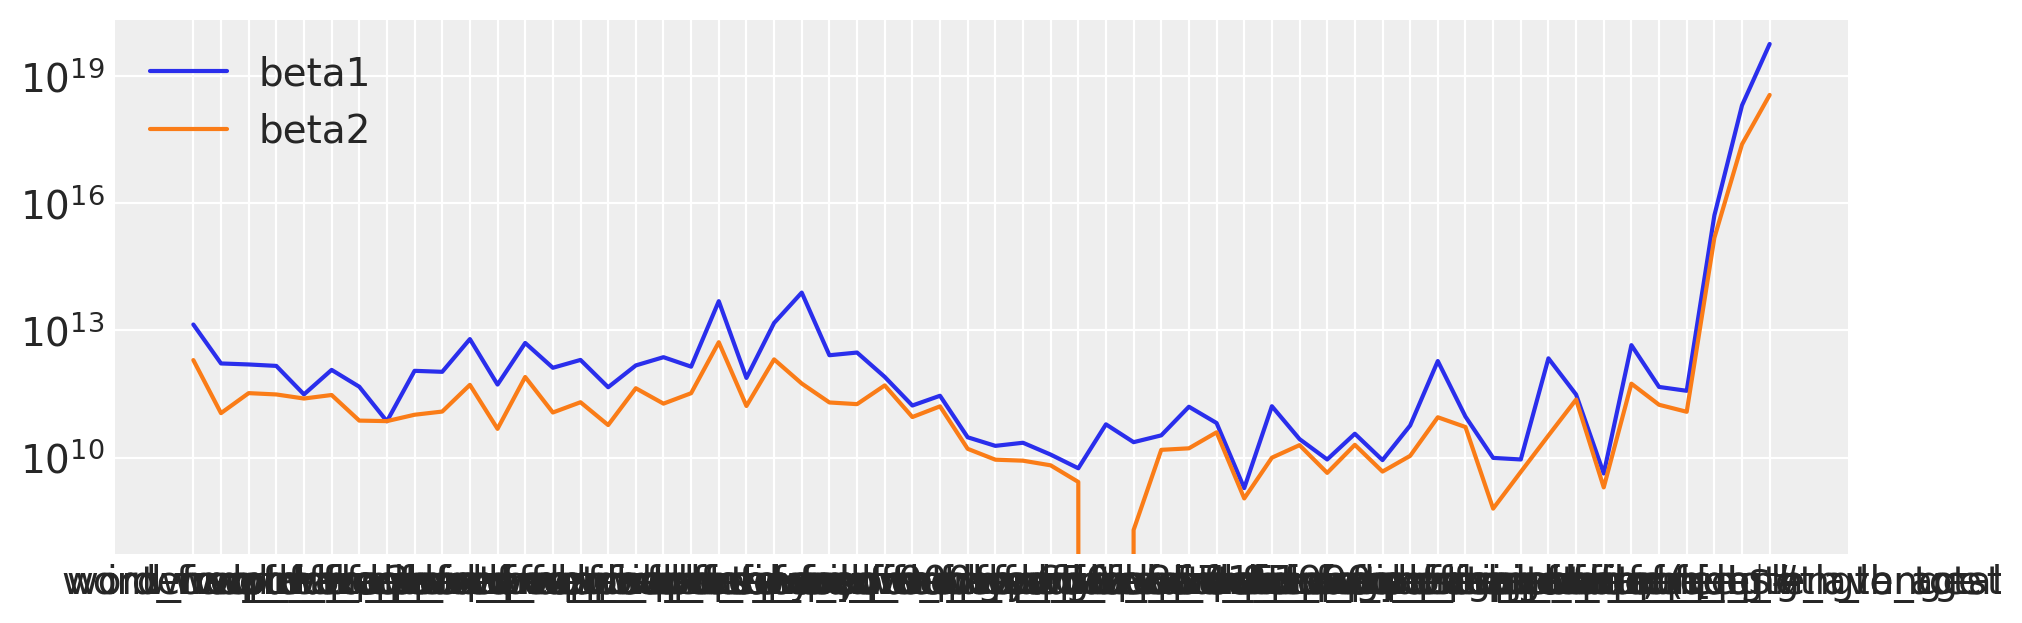

In [21]:
plt.figure(figsize=(10, 3))
coeff = np.random.randint(k)
std_betas1 = betas1.mean(axis=0)*sigma
std_betas2 = betas2.mean(axis=0)*sigma
plt.plot(std_betas1,label='beta1')
plt.plot(std_betas2,label='beta2')
plt.yscale("log")
plt.legend()
plt.show()

In [ ]:
def sample_sas(nu,pi,T):

    betas = np.zeros((T,k))
    lambdas = np.zeros((T,n))
    gammas = np.ones((T,k))

    betas[0] = rng.normal(0,1,size=k)
    lambdas[0] = rng.normal(0,1,size=n)
    gammas[0] = np.ones(k).astype(int)

    lambdas_idx = list(range(n))
    
    # We need to initialize B and b

    for t in range(1,T):
        
        if t % 100 == 0:
            print("Step {}".format(t))
        
        # Do we need to keep that part ? I would say yes just to get rid of the support vectors
        # num_lambda = numerical(1/lambdas[t-1])
        # if num_lambda[0]:
        #     print("At time", t)
        #     idx, tag = num_lambda[1], num_lambda[2]
        #     print("Found a numerical issue for lambda, in position {}, with value {}".format(i,tag))
        #     print("Support vector found at index {}".format(i))
        #     lambdas[:,idx] = np.nan
        #     for i in idx:
        #         if i in lambdas_idx:
        #             lambdas_idx.remove(i)
        #     print('Remaining coeffs in lambda : {}'.format(len(lambdas_idx)))
            
        # Sampling lambda using beta
        for i in lambdas_idx:
            lambda_inv = rng.wald(1/np.abs(1-X[i][gamma[t-1].T @ betas[t][gamma[t-1]]), 1)
            if lambda_inv == 0.0:
                lambdas[t,i] = np.inf
            else:
                lambdas[t,i] = 1/lambda_inv
                                                  
        # Sampling gamma using previous state
        # How to do that ? Compute for each term, normalize and then choose between 0 and 1 for each gamma_i ?
        # Where do the values of gamma_i and gamma_(i-1) intervene in the expression ?

        # Computing B and b
        term1 = nu**(-2)* sigma2_inv[omegas_idx,:][:,omegas_idx] @ np.diag(1/omegas[t-1][omegas_idx])
        term2 = X[lambdas_idx,:][:,omegas_idx].T @ np.diag(1/lambdas[t-1][lambdas_idx]) @ X[lambdas_idx,:][:,omegas_idx]
        B = term1 + term2
        b = B @ X[lambdas_idx,:][:,omegas_idx].T @ (np.ones(len(lambdas_idx)) + 1/lambdas[t-1][lambdas_idx])

        # Sampling beta using previous state
        betas[t][omegas_idx] = rng.multivariate_normal(b, cov=B)
    
    return betas

In [ ]:
pi = 1/2 * np.ones(k)
nu = 100
T = 100

betas3 = sample_sas(nu,pi,T)

In [ ]:
pi = 0.01 * np.ones(k)
nu = 100
T = 100

betas4 = sample_sas(nu,pi,T)